In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm
%matplotlib notebook

In [2]:
G_Drive = 'C:\\Users\\User\\Google Drive\\'
Dpath = G_Drive+'FishIsland_Outputs/Upscaled_Estimates.csv'

Data = pd.read_csv(Dpath,index_col=['datetime'],parse_dates=['datetime'])
Data = Data.drop(columns=['datetime.1'])
Data.head()

,fch4,fco2,ch4_flux,co2_flux,Air_Temp,Rainfall,wind_speed,Wind_Direction,Net_SW,Net_LW,...,NME_est_FP_20,NME_est_FP_21,NME_est_FP_22,NME_est_FP_23,NME_est_FP_24,NME_est_FP_25,NME_est_FP_26,NME_est_FP_27,NME_est_FP_28,NME_est_FP_29
datetime,,,,,,,,,,,,,,,,,,,,,
2009-05-01 00:00:00,NaN,NaN,NaN,NaN,-1.0,NaN,2.1,78.0,-2.47,-43.32,...,20.083914,36.466330,43.334080,36.966366,36.740337,26.774300,21.947300,31.645071,34.334827,24.286350
2009-05-01 01:00:00,NaN,NaN,NaN,NaN,-1.3,NaN,1.9,102.4,-2.58,-40.42,...,20.842901,37.694695,43.714054,37.664795,36.463460,27.161098,22.669683,32.460133,34.410305,24.762468
2009-05-01 02:00:00,NaN,NaN,NaN,NaN,-1.1,NaN,2.2,154.3,-1.94,-38.93,...,19.531267,36.863150,44.002754,37.539757,36.727398,27.292000,21.720339,31.458931,33.973660,24.111258
2009-05-01 03:00:00,NaN,NaN,NaN,NaN,-1.4,NaN,2.4,155.8,-1.99,-38.63,...,18.678095,36.174164,44.179360,37.327110,36.891420,27.036308,21.039034,31.185660,33.684715,23.634840
2009-05-01 04:00:00,NaN,NaN,NaN,NaN,-1.2,NaN,2.0,168.4,-1.84,-35.40,...,20.568995,38.073570,44.350070,38.331146,36.461025,27.722485,22.479235,32.409557,34.067673,24.619650


# Validation

In [3]:
X = 'fch4'
y = 'NME_est_FP'

# X = 'fco2'
# y = 'NEE_est'

DNA=(Data[[X,y]].dropna())
print('r2',(metrics.r2_score(DNA[X],DNA[y])*100).round(2))
print('RMSE',(metrics.mean_squared_error(DNA[X],DNA[y])**.5).round(2))
print('MAE',(metrics.mean_absolute_error(DNA[X],DNA[y])).round(2))

X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(est2.summary())
with open(G_Drive+'PhD_Thesis\\Chapter3_Figs/'+X[0]+'_v_'+y+'_summary.txt', 'w') as fh:
    fh.write(est2.summary().as_text())


r2 68.66
RMSE 6.89
MAE 5.19
                            OLS Regression Results                            
Dep. Variable:             NME_est_FP   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     1929.
Date:                Mon, 07 Mar 2022   Prob (F-statistic):          9.22e-214
Time:                        13:33:35   Log-Likelihood:                -2382.0
No. Observations:                 788   AIC:                             4768.
Df Residuals:                     786   BIC:                             4777.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8564   

# Yearly

In [11]:
Yearly = Data.resample('Y').mean()[['Air_Temp']]
Yearly[['Peak_NDVI','Peak_Thaw_Depth']] = Data.resample('Y').max()[['NDVI_FI_LCP','Active_Layer_1']]
for index,row in Yearly.iterrows():
    y =index.year
    Yearly.loc[Yearly.index==index,'Peak_GS_Date']=Data.loc[((Data.index.year==y)&
        (Data['NDVI_FI_LCP']==row['Peak_NDVI']))].index.date[0]

Data['Full_Season']=np.nan
Data.loc[Data['Active_Layer_1'].isnull()==False,'Full_Season']=1

Data['Thaw_Season']=np.nan
Data.loc[((Data['Full_Season']==1)&(Data['NDVI_FI_LCP']<0.25)),'Thaw_Season']=1

Data['Early_Growing_Season']=np.nan
Data['Peak_Growing_Season']=np.nan
Data['Senescent_Season']=np.nan

for index,row in Yearly.iterrows():
    y = index.year
    Data.loc[((Data.index.year==y)&(Data['NDVI_FI_LCP']/row['Peak_NDVI']<0.9)&(Data['NDVI_FI_LCP']>=0.25)&
              (Data.index.date<row['Peak_GS_Date'])&(Data['Full_Season']==1)),'Early_Growing_Season']=1
    
    Data.loc[((Data.index.year==y)&(Data['NDVI_FI_LCP']/row['Peak_NDVI']>=0.9)&
              (Data['Full_Season']==1)),'Peak_Growing_Season']=1
    
    Data.loc[((Data.index.year==y)&(Data['NDVI_FI_LCP']/row['Peak_NDVI']<0.9)&
              (Data.index.date>row['Peak_GS_Date'])&(Data['Full_Season']==1)),'Senescent_Season']=1
       
Data['Date'] = Data.index.date
# Data['Melt_Start'] = Data.index.date
Yearly['Melt_Date'] = Data.loc[Data['Full_Season']==1].resample('Y').min()['Date']
Yearly['GS_Date'] = Data.loc[Data['NDVI_FI_LCP']>=0.25].resample('Y').min()['Date']
Yearly['Senescent_Date'] = Data.loc[Data['Senescent_Season']==1].resample('Y').min()['Date']
Yearly['End_Date'] = Data.loc[Data['Full_Season']==1].resample('Y').max()['Date']

Yearly.round(2)
Yearly.set_index(Yearly.index.year)[['Melt_Date','End_Date']]

,Melt_Date,End_Date
datetime,,
2009,2009-06-10,2009-09-23
2010,2010-06-02,2010-09-22
2011,2011-06-02,2011-09-27
2012,2012-06-02,2012-10-06
2013,2013-06-10,2013-10-21
2014,2014-06-05,2014-10-02
2015,2015-06-03,2015-09-27
2016,2016-05-29,2016-10-05
2017,2017-06-03,2017-10-09


In [6]:
S

In [ ]:
Data.loc[((Data.index.day == 31)&(Data.index.month==10)),'Season']=np.nan
Data['GS']=np.nan

Max_NDVI = (Data.resample('Y').max()[['NDVI_interp']])
for i,row in Max_NDVI.iterrows():
    MxD = Data.loc[((Data.index.year==i.year)&(Data.NDVI_interp==row['NDVI_interp']))].index.dayofyear[0]
    Max_NDVI.loc[Max_NDVI.index.year==i,'Max_Day']=MxD
    Data.loc[((Data.index.year==i.year)&(Data.index.dayofyear<=MxD)
             &(Data.NDVI_interp>=0.25)),'GS']=1
    Data.loc[((Data.index.year==i.year)&(Data.index.dayofyear>=MxD)
             &(Data.NDVI_interp/row['NDVI_interp']>=0.9)),'GS']=1
    Data.loc[((Data.index.year==i.year)&(Data.index.dayofyear>=MxD)
             &(Data.NDVI_interp/row['NDVI_interp']<=0.9)&(Data['Season']==1)),'GS']=0.5

Data['Season_Days'] = Data['Season']*Data.index.dayofyear
Data['GS_Days'] = Data['GS']*Data.index.dayofyear
Data['Season_Dates']=pd.to_datetime(Data.index.year * 1000 + Data['Season_Days'], format='%Y%j')
Data['GS_Dates']=pd.to_datetime(Data.index.year * 1000 + Data['GS_Days'], format='%Y%j')
    
print(Data.resample('Y').sum()[['Season','GS']]/24)
print(Data.resample('Y').min()[['Season_Dates','GS_Dates']])
print(Data.resample('Y').max()[['Season_Dates','GS_Dates']])   
    
Study_Year = Data.loc[Data.index.year == 2019]

plt.figure()
plt.plot(Study_Year[['Season']],color='k',linewidth=4)
# plt.plot(Study_Year[['GS']]+1)
x2 = plt.twinx()
# x2.plot(Study_Year['NDVI_interp']*100,color='orange')
x2.plot(Study_Year['NDSI_interp'],color='b')
x2.plot(Study_Year['snow_cover'],color='r')
print(Study_Year['ndvi_FI_LCP'].dropna())

<IPython.core.display.Javascript object>


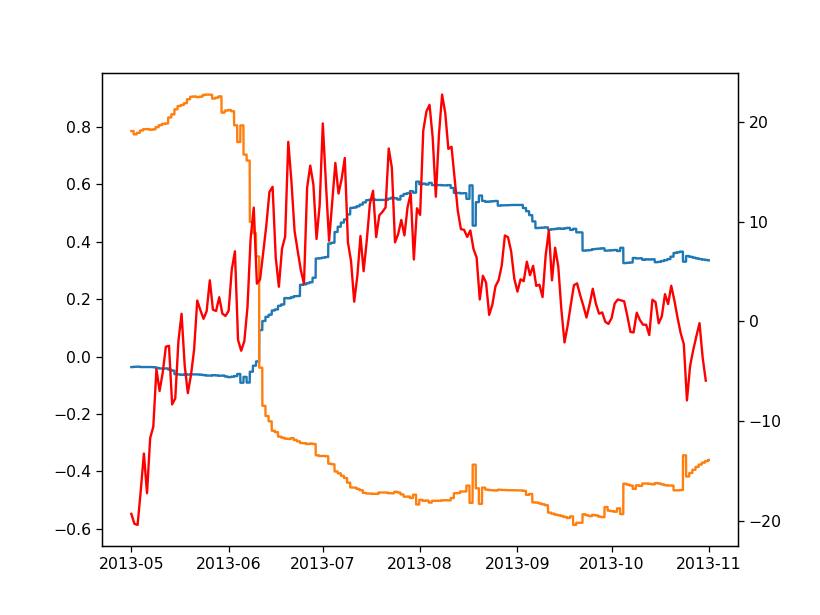

In [23]:
Study_Year = Data.loc[Data.index.year==2013]
# plt.figure()
# plt.scatter(Data['Full_Season'],Data['NDVI_FI_LCP'])
plt.plot(Study_Year['NDVI_FI_LCP'])
plt.plot(Study_Year['NDSI_FI_LCP'])
# # plt.plot(Study_Year['Snow'])
# # plt.plot(Study_Year['Season'])
ax2 = plt.twinx()
ax2.plot(Study_Year['Air_Temp'].resample('D').mean(),color='r')
# ax2.plot(Study_Year['snow_cover'],color='g')